
# Clean-up and Translation

Imagine we have a tile of locations, say "cortical columns" that tile the visual field. 

Each column represents a patch of the full visual space. And each patch encodes the visual features with the same set of sparse filters and code words.

The strategy here is to assign each column a "pointer", that corresponds with its unique location tiling the visual field. With these pointers, we can translate an image by manipulating the pointers themselves. 

To manipulate the pointers, we need to add a key aspect of normal computing to HD computing: pointer arithmetic. Think about how we would perform image translation on a real computer -- we would take the original image matrix and shift the indexes, i.e. add or subtract from the pointers to the memory. Having a pointer arithmetic could be very powerful for connectionist/neural-networks.

First, lets do the pca-ica sparse encoding of the image.


In [1]:
from __future__ import division

from pylab import *
import scipy
import time

import imnet_utils as imut
import sklearn
from sklearn.decomposition import PCA, FastICA, TruncatedSVD, NMF

%matplotlib inline

plt.rcParams.update({'axes.titlesize': 'xx-large'})
plt.rcParams.update({'axes.labelsize': 'xx-large'})
plt.rcParams.update({'xtick.labelsize': 'x-large', 'ytick.labelsize': 'x-large'})
plt.rcParams.update({'legend.fontsize': 'x-large'})
plt.rcParams.update({'text.usetex': True})

In [2]:
def norm_range(v):
    return (v-v.min())/(v.max()-v.min())

## Tiled Sparse Coding for Encoding Visual Features

Here, we are just going through the normal routine of encoding visual space using PCA-ICA to make sparse features. I've done it a bit differently, so that the mean of the image isn't lost and the image doesn't have to be `norm_range`d to be displayed. This way I can make a tile of independent visual location to encode a larger image and still keep smooth boundaries between each tile (i.e. each tile doesn't have to be independently renormalized).



In [3]:
reload(imut)
patch_size=(10,10)
tstart = time.time()
impatches = imut.load_random_imnet_patches(100000, patch_size=patch_size)
print "Duration: ", time.time() - tstart


0 1000 2000 3000 4000 5000 6000 7000 8000 9000 10000 11000 12000 13000 14000 15000 16000 17000 18000 19000 20000 21000 22000 23000 24000 25000 26000 27000 28000 29000 30000 31000 32000 33000 34000 35000 36000 37000 38000 39000 40000 41000 42000 43000 44000 45000 46000 47000 48000 49000 50000 51000 52000 53000 54000 55000 56000 57000 58000 59000 60000 61000 62000 63000 64000 65000 66000 67000 68000 69000 70000 71000 72000 73000 74000 75000 76000 77000 78000 79000 80000 81000 82000 83000 84000 85000 86000 87000 88000 89000 90000 91000 92000 93000 94000 95000 96000 97000 98000 99000 Duration:  64.0410339832


In [4]:
import glob

im_list = glob.glob('data/image_net/*')
print len(im_list)

12226


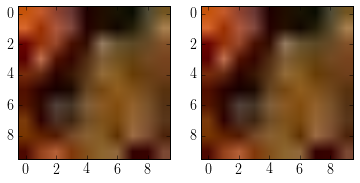

In [11]:
impatchr = impatches.copy().reshape((-1, impatches.shape[3]))

impatchr -= 1
impatchr /= 255



irec = impatchr[:, 22].reshape((impatches.shape[0], impatches.shape[1], impatches.shape[2]))

subplot(121)
imshow((impatches[:,:,:,22]-1)/255)
subplot(122)
imshow(irec)

In [ ]:
impatchr -= impatchr.mean(axis=1)[:, np.newaxis]


In [12]:
mean01 = impatchr.mean()

In [13]:
impatchr -= impatchr.mean()

In [14]:

ncomponents = 250

pca_encoder = TruncatedSVD(ncomponents)
fica_encoder = FastICA(ncomponents)



In [15]:
tstart = time.time()
pca_encoder.fit(impatchr.T)
print 'Duration: ', time.time() - tstart


Duration:  19.8257248402


In [16]:
scores = pca_encoder.transform(impatchr.T)

In [17]:
pc_comp = pca_encoder.components_

print pc_comp.shape

pc_comp_ims = pc_comp.T.reshape((impatches.shape[0], impatches.shape[1], impatches.shape[2], -1))

(250, 300)


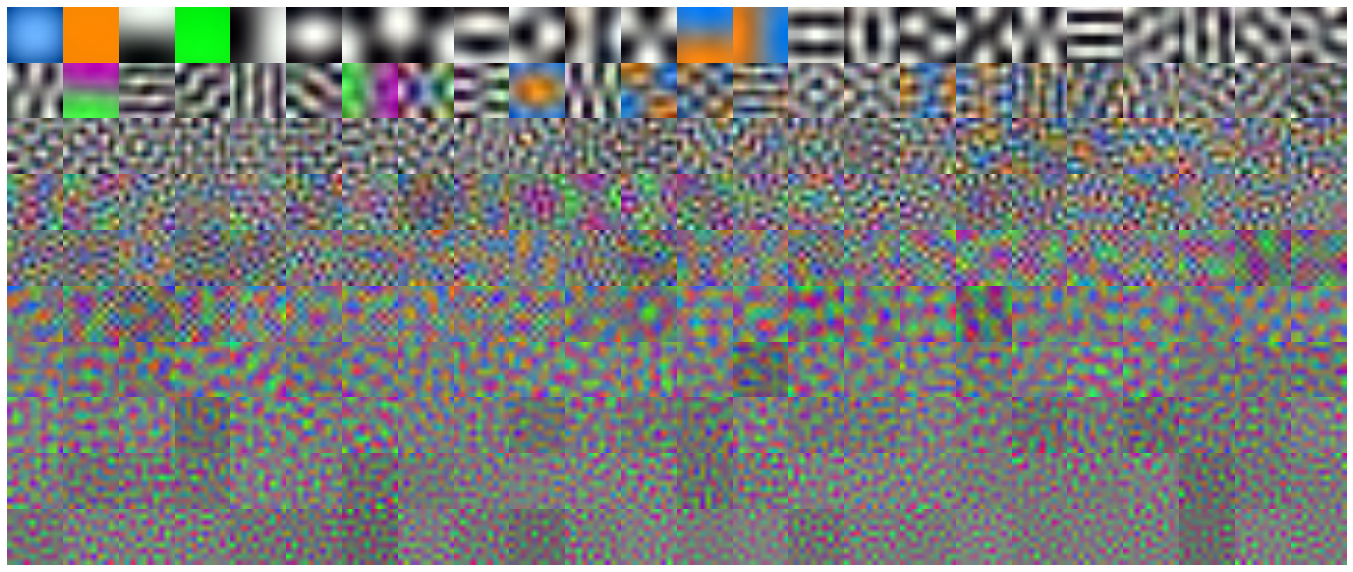

In [18]:
plt.rcParams['figure.subplot.hspace'] = 0
plt.rcParams['figure.subplot.wspace'] = 0

figure(figsize=(24,10))

nshow = 240
maxrow = 24
for i in range(nshow):
    ax=subplot(nshow//maxrow,maxrow,i+1)
    imshow(norm_range(pc_comp_ims[:,:,:,i]))
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_frame_on(False)


In [19]:
tstart = time.time()
which_pcs = np.arange(150)
fica_encoder.fit(scores[:,which_pcs])
print 'Duration: ', time.time() - tstart


n_components is too large: it will be set to 150
Duration:  132.568167925


In [20]:
ic_scores = fica_encoder.transform(scores[:1000,which_pcs])

In [21]:
pc_scores = scores[:ic_scores.shape[0], :ic_scores.shape[1]]


In [22]:
ic_comp = fica_encoder.components_
ic_comp /= ic_comp.std(axis=0)
ic_comp = np.dot(ic_comp, pc_comp[which_pcs,:])
print ic_comp.shape

(150, 300)


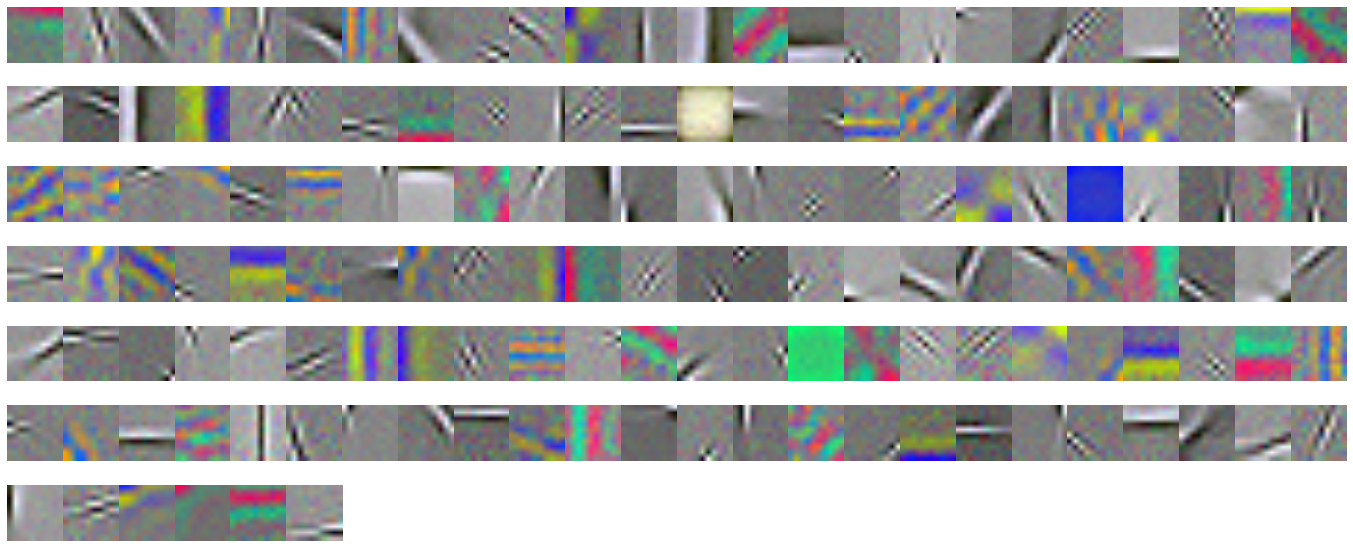

In [23]:
ic_comp_ims = ic_comp.T.reshape((impatches.shape[0], impatches.shape[1], impatches.shape[2], -1))
figure(figsize=(24,10))
nshow = min(len(which_pcs), 240)
maxrow = 24
for i in range(nshow):
    ax=subplot(nshow//maxrow+1,maxrow,i+1)
    imshow(norm_range(ic_comp_ims[:,:,:,i+0]))
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_frame_on(False)


In [24]:
nrecon = 16
impatch = imut.load_random_imnet_patches(nrecon, patch_size)
#impatch = impatches[:,:,:,58]
impatchr = impatch.reshape((-1, nrecon))
impatchr -= impatchr.mean(axis=1)[:, np.newaxis]

ic_c = linalg.lstsq(ic_comp.T, impatchr)
pc_c = linalg.lstsq(pc_comp[which_pcs,:].T, impatchr)
ic_code = ic_c[0].T
pc_code = pc_c[0].T

0


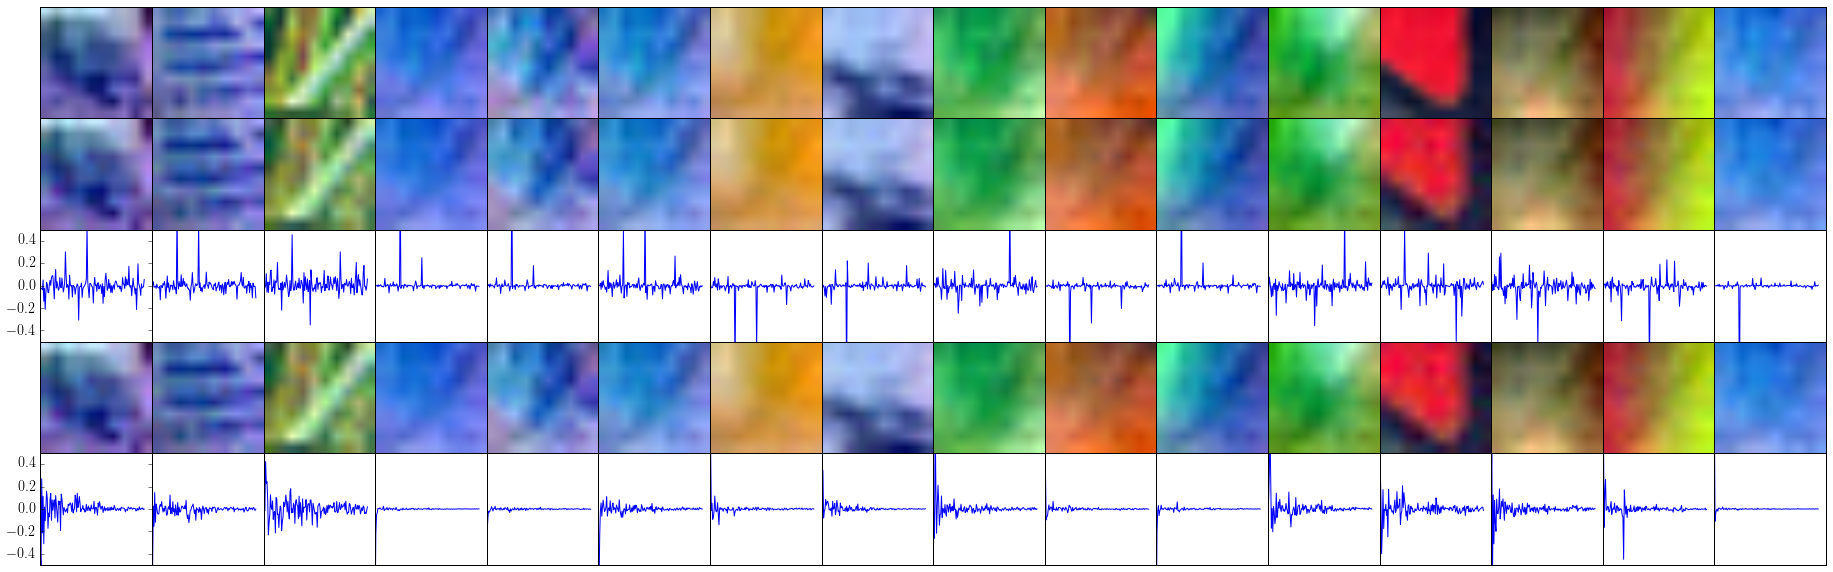

In [25]:


figure(figsize=(32, 10))

for imx in range(nrecon):
    
    ax = subplot(5, nrecon, imx + 1)
    imp = impatchr[:,imx].reshape(patch_size[0], patch_size[1], 3)
    imshow(norm_range(imp))
    ax.set_xticks([])
    ax.set_yticks([])
    
    ax = subplot(5, nrecon, imx + 1 + nrecon)
    ic_recon = np.dot(ic_code[imx,:], ic_comp)
    ic_reconr = ic_recon.reshape(patch_size[0], patch_size[1], 3)
    imshow(norm_range(ic_reconr))
    ax.set_xticks([])
    ax.set_yticks([])
    
    
    ax = subplot(5, nrecon, imx + 1 + 2*nrecon)
    plot(ic_code[imx,:].T/norm(ic_code[imx, :]))
    ax.set_xticks([])
    ax.set_ylim([-0.5, 0.5])
    if imx > 0:
        ax.set_yticks([])

    ax = subplot(5, nrecon, imx + 1 + 3*nrecon)
    pc_recon = np.dot(pc_code[imx,:], pc_comp[which_pcs,:])
    pc_reconr = pc_recon.reshape(patch_size[0], patch_size[1], 3)
    imshow(norm_range(pc_reconr))
    ax.set_xticks([])
    ax.set_yticks([])
    
    ax = subplot(5, nrecon, imx + 1 + 4*nrecon)
    plot(pc_code[imx,:].T/norm(pc_code[imx, :]))
    ax.set_xticks([])
    ax.set_ylim([-0.5, 0.5])
    if imx > 0:
        ax.set_yticks([])


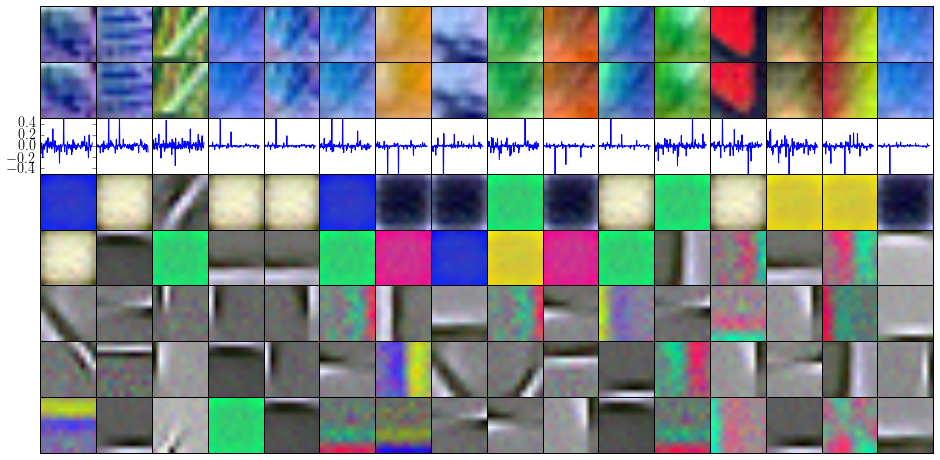

In [26]:
figure(figsize=(16, 8))

ic_ex = 2*arange(5)+1
nrows = 3 + len(ic_ex)
for imx in range(nrecon):
    
    ax = subplot(nrows, nrecon, imx + 1)
    imp = impatchr[:,imx].reshape(patch_size[0], patch_size[1], 3)
    imshow(norm_range(imp))
    ax.set_xticks([])
    ax.set_yticks([])
    
    ax = subplot(nrows, nrecon, imx + 1 + nrecon)
    ic_recon = np.dot(ic_code[imx,:], ic_comp)
    ic_reconr = ic_recon.reshape(patch_size[0], patch_size[1], 3)
    imshow(norm_range(ic_reconr))
    ax.set_xticks([])
    ax.set_yticks([])
    
    
    ax = subplot(nrows, nrecon, imx + 1 + 2*nrecon)
    plot(ic_code[imx,:].T/norm(ic_code[imx, :]))
    ax.set_xticks([])
    ax.set_ylim([-0.5, 0.5])
    if imx > 0:
        ax.set_yticks([])

          
    idx_max = np.argsort(abs(ic_code[imx,:]))
  
    for ici,icx in enumerate(ic_ex):
        ax = subplot(nrows, nrecon, imx + 1 + (3+ici)*nrecon)
        ic_compr = ic_comp[idx_max[-icx],:].reshape(patch_size[0], patch_size[1], 3) 
        ic_compr = ic_compr * ic_code[imx, idx_max[-icx]] # this just flips it if its negative
        imshow(norm_range(ic_compr))
        ax.set_xticks([])
        ax.set_yticks([])
    


In [220]:
def draw_ic_im(ic_coef, ic_comps, nx, ny, patch_size):
    im = np.zeros((int(nx*patch_size[0]), int(ny*patch_size[1]), 3))
    
    cfx = 0
    for ix in range(nx):
        for iy in range(ny):
            ic_recon = np.dot(ic_coef[cfx], ic_comps)
            ic_reconr = ic_recon.reshape(patch_size[0], patch_size[1], 3)
            
            ic_reconr = (ic_reconr + mean01)
            
            ic_reconr[ic_reconr<0] = 0 
            ic_reconr[ic_reconr>1] = 1
            
            
            im[ix*patch_size[0]:(ix+1)*patch_size[0], 
                      iy*patch_size[1]:(iy+1)*patch_size[1], :] = ic_reconr #norm_range(ic_reconr)
            cfx+=1
            
    return im


## FHRR and Pointer Arithmetic

In order to enable the appropriate pointer arithmetic to translate the image, I am using FHRR, which uses complex vectors. 

The reason FHRR has an advantage is that the binding operation can be iteratively applied to create new unique vectors, whereas in bipolar spatter code, the binding operation applied twice leads to the binding identity (i.e. all vectors are their self-inverses). This not the case in FHRR. Not only that, but also FHRR allows for intermediate binding/interpolation/fractional binding. This is akin to raising a vector to a fractional power. This could be really useful if we can make a set of visual basis functions that also can be interpolated across, but we will come back to this another time.

The primary reason we want FHRR is to enable pointer arithmetic, and we can perform translation by carefully defining each "pointer" for each of the cortical columns tiling visual space. We create such pointers by defining two random vectors that are unique symbols for horizontal ($H$) and vertical ($V$) position. Each column tiles the visual space and has a unique pointer created by $H$ and $V$. Neighboring regions are related by the number of times $H$ and $V$ are bound together.

For instance, imagine we have 12 columns that tile visual space in a 3x4 grid. Then the location pointers for each column is given by:

||
| :------------: | :--------------: | :--------------: | :--------------: |
| $H \times V$  | $H^2 \times V$   | $H^3 \times V$  </br> | $H^4 \times V$ </br>|
| $H \times V^2$ | $H^2 \times V^2$ | $H^3 \times V^2$ </br>| $H^4 \times V^2$ </br>|
| $H \times V^3$ | $H^2 \times V^3$ | $H^3 \times V^3$ </br>| $H^4 \times V^3$ </br>|



In [28]:
def fhrr_vec(D, N):
    # pick a random phase
    rphase = 2 * np.pi * np.random.rand(D, N // 2)

    fhrrv = np.zeros((D, 2 * (N//2)))
    fhrrv[:, :(N//2)] = np.cos(rphase)
    fhrrv[:, (N//2):] = np.sin(rphase)
    
    return fhrrv

def fhrr_inv(a):
    N2 = a.shape[1] // 2
    b = np.zeros_like(a)
    b[:,:N2] = a[:, :N2]
    b[:,N2:] = -a[:, N2:]
    
    return b

def fhrr_bind(a, b, pa=1, pb=1):
    # we want to do element wise multiply of complex numbers
    N2 = a.shape[1] // 2
    
    
    if not pa==1:
        a = fhrr_pow(a, pa)
        
    if not pb==1:
        b = fhrr_pow(b, pb)
  
    ra = a[:, :N2]
    ia = a[:, N2:]
    rb = b[:, :N2]
    ib = b[:, N2:]
              
    c = np.zeros_like(a)
    
    c[:, :N2] = ra * rb - ia * ib
    c[:, N2:] = ra * ib + rb * ia
    
    return c
 
    
def fhrr_pow(a, pa=1):
    N2 = a.shape[1] // 2
    
    ra = a[:, :N2]
    ia = a[:, N2:]
    
    if not pa == 1:
        ma = (ra**2 + ia**2) ** (pa/2) 
        aa = pa * (np.arctan(ia/ra) + (ra < 0) * np.pi)
        ra = ma * np.cos(aa)
        ia = ma * np.sin(aa)
        
    c = np.zeros_like(a)
    c[:, :N2] = ra
    c[:, N2:] = ia
    
    return c
    
def fhrr_roll(a, r=1):
    N2 = a.shape[1] // 2
    c = np.zeros_like(a)
    c[:, :N2] = np.roll(a[:, :N2], r, axis=1)
    c[:, N2:] = np.roll(a[:, N2:], r, axis=1)
    
    return c

def fhrr_cc(a, b):
    
    pass
    

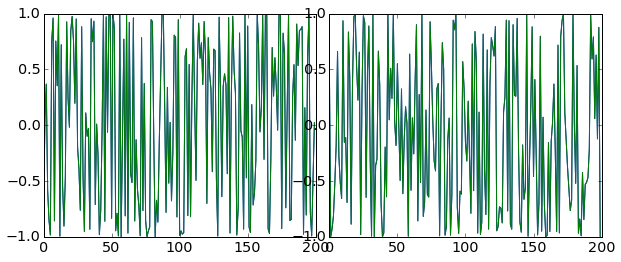

In [301]:
plt.rcParams.update({'text.usetex': False})

bb = fhrr_bind(loc_hyperbase[[0],:], loc_hyperbase[[0],:])
bc = fhrr_bind(bb, loc_hyperbase[[0],:])

bp = fhrr_pow(loc_hyperbase[[0], :], pa=2)

cc = fhrr_bind(loc_hyperbase[[0],:], loc_hyperbase[[1],:], pa=3, pb=1)

figure(figsize=(10,4))
subplot(121)
plot(bb[0,0:200])
#plot(cc[0,0:200])
plot(bp[0,0:200])
subplot(122)
plot(bb[0,N//2:(N//2+200)])
plot(bp[0,N//2:(N//2+200)])
#plot(cc[0,N//2:(N//2+200)])


## Multi-region clean-up memory

The "retina" encodes the image with the pointers in mind. Each 10x10 pixel tile of the image will find sparse coefficients of the image patch using the same set of basis functions. These coefficients will then be bound to the position vectors based on where the image patch is in the tiling. All of this information will be dumped into a global workspace, the "thalamus". 

Whatever information that is in the thalamus, the cortical columns will try and clean it up and this should reproduce the image. The thalamus then might look something like this:

$$
T = H \times V \times I_{1,1} + H^2 \times V \times I_{1,2} + H^3 \times V^2 \times I_{2,3}
$$

Lets go through the process of encoding an image using these location pointers, superposing all of the image information bound to the pointers in a global worksapce, and then cleaning the image up from the global workspace. First just make the symbol vectors:

In [334]:
N=50000
icD = len(which_pcs)
ic_hyperpatch = fhrr_vec(icD, N)

nx_patch = 5
ny_patch = 5

loc_hyperbase = fhrr_vec(2, N) #2*(np.random.randn(2, N) < 0) - 1

code_vecs = []

for ix in range(nx_patch):
    for iy in range(ny_patch):
        
        code_v = fhrr_bind(loc_hyperbase[[0],:], loc_hyperbase[[1],:], pa=(ix+1), pb=(iy+1))
        #code_v = fhrr_bind(fhrr_roll(loc_hyperbase[[0],:], ix+1), 
        #                   fhrr_roll(loc_hyperbase[[1],:], iy+1))
        ic_code = fhrr_bind(np.tile(code_v, (icD, 1)), ic_hyperpatch)
        
        code_vecs.append(ic_code)
        

Now load some larger example images:

In [302]:
nrecon = 16
big_patch_size = (patch_size[0] * nx_patch, patch_size[1] * ny_patch)

impatch = imut.load_random_imnet_patches(nrecon, big_patch_size)



0


The "retina" will then take this large image and break it down into a set of tiles and encode each tile with the same visual basis functions. In this example, the basis functions are for 10x10x3 pxiel patches, and we have a 3x3 grid of such patches, allowing us to encode a 30x30 pixel image. 

In [304]:
#

ic_im_vecs = []

for ix in range(nx_patch):
    for iy in range(ny_patch):
        imp = impatch[ix*patch_size[0]:(ix+1)*patch_size[0], 
                      iy*patch_size[1]:(iy+1)*patch_size[1], :]
        impatchr = imp.reshape((-1, nrecon)).copy()
        impatchr = (impatchr-1)/255
        #impatchr -= impatchr.mean(axis=1)[:, np.newaxis]
        impatchr -= mean01

        ic_c = linalg.lstsq(ic_comp.T, impatchr)
        ic_code = ic_c[0].T
        ic_im_vecs.append(ic_code)
        

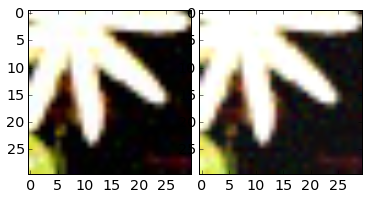

In [66]:
im_idx = 3
icima = np.array(ic_im_vecs)
subplot(121)
imshow(257-impatch[:,:,:,im_idx])
subplot(122)
imshow(draw_ic_im(255*icima[:,im_idx,:], ic_comp, nx_patch, ny_patch, patch_size))


**Figure: Encoding large image with tiled sparse coding regions.** Left: raw 50x50 image, Right: reconstructed from 5x5 patches of sparse coefficients.

The key to all of this working is that we need to build a clean up memory to reconstruct the image from the global workspace. To create this clean-up memory, I am going to perform an iterative process similar to the resonance attractor for unbinding two vectors. However, this is slightly different because I am inferring several vectors that are summed together (but each is bound to a location pointer), instead of vectors bound together.

The idea is quite simple, and can be easily explained using HD alebra. If we are given a $T$ vector described above, then it is straightforward for each column to decode the image features from the global workspace. Each column would just need to store the symbols for the image features bound with the column's unique pointer. Extracting the features from the global workspace is simply performing the dot product of the global workspace and this columns stored symbols:

$$
I_{i,j} = T \cdot (H^j \times V^i \times I)
$$

Similar to the unbinding, this will have a noisy readout, but we can improve this noise by performing this operation iteratively and subtracting out each column's contribution to the input -- i.e. each region tries to explain away $T$ by subtracting out the individual column's representation from the global worksapce. 

This can also be thought of as each column receiving the *residuals* of the thalamus, resonating with the residuals, and sending back the portion of the residuals that resonate with the region's basis vectors to be subtracted out from the global workspace. Each region would then maintain any energy that resonated with the input, and effectively shift the information in the thalamus to the cortical columns. 

Multiple iterations of this acts as a clean-up memory, and can recover the original image from the global workspace:

In [51]:
n_steps = 10

cc_states = []
cc_hist = []
resonances = []
#eignorm = 1
#obj_resonance = np.dot(np.dot(pinv(obj_vecs), eignorm * np.eye(objD)), obj_vecs)

bound_imvec = np.zeros(N)

for iCC in range(len(code_vecs)):
    cc_s = np.random.randn(N)
    cc_h = np.zeros((n_steps, icD))
    
    imv = np.dot(ic_im_vecs[iCC][im_idx, :], code_vecs[iCC])
    
    bound_imvec += imv
    
    cc_states.append(cc_s)
    cc_hist.append(cc_h)
    eignorm = 1
    res = np.dot(np.dot(pinv(code_vecs[iCC]), eignorm * np.eye(icD)), code_vecs[iCC])
    resonances.append(res)
    
thal_vec = bound_imvec.copy()

for i in range(n_steps):
    thal_vec[:] = bound_imvec
    for iCC in range(len(code_vecs)):
        cc_hist[iCC][i,:] = np.dot(code_vecs[iCC], cc_states[iCC])
        
        thal_vec -= cc_states[iCC]
        
    for iCC in range(len(code_vecs)):
        
        cc_states[iCC] = np.dot(resonances[iCC], thal_vec+cc_states[iCC])
 

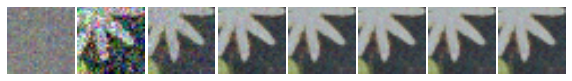

In [62]:
plt.rcParams['figure.subplot.hspace'] = 0
plt.rcParams['figure.subplot.wspace'] = .05

figure(figsize=(10,8))

maxrow = 8
nshow =8

for i in range(nshow):
    ax=subplot(nshow//maxrow+1,maxrow,i+1)
    
    im = draw_ic_im(255*cc_hista[:, i, :]/N, ic_comp, nx_patch, ny_patch, patch_size)
    imshow(im)    
    
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_frame_on(False)




** Clean up of Global Workspace ** An image is encoded by the retina and transferred to a global workspace. Each tile of the image is encoded with the same visual features, but bound with its location pointer before superposed. The cortical columns attempt to clean-up the global workspace and recover the visual features bound to each location. The first iteration is initialized to random (left), and after one step the image is mostly recovered (second-left). Further iterations reduce the noise, but some noise still remains. 


## Translation using Pointer Arithmetic

Now we are set-up to actually perform translation. With the system capable of cleaning-up the gloabl workspace to recover the image, we can now manipulate the pointers in the global workspace to translate the image features. 

Because we carefully designed the construction of the pointers, it is quite easy to translate the image. To shift the image to the left, we can take the entire global workspace and *bind* it to the $H$ vector. This will distribute across all the pointers and increment the power of the pointer by one, which means that the information bound to $H \times V$ is now bound to $H^2 \times V$. The clean-up memory will take care of the rest and the image can be recovered. We can also move left by $T \times H^{-1}$:


In [281]:
n_steps = 16

cc_states = []
cc_hist = []
#resonances = []
#eignorm = 1
#obj_resonance = np.dot(np.dot(pinv(obj_vecs), eignorm * np.eye(objD)), obj_vecs)

bound_imvec = np.zeros(N)
cv_inv = []

for iCC in range(len(code_vecs)):
    cc_s = np.random.randn(N)
    cc_h = np.zeros((n_steps, icD))
    
    cv_inv.append(pinv(code_vecs[iCC]))
    imv = np.dot(ic_im_vecs[iCC][im_idx, :], code_vecs[iCC])
    
    bound_imvec += imv
    
    cc_states.append(cc_s)
    cc_hist.append(cc_h)
    eignorm = 1
    #res = np.dot(np.dot(pinv(code_vecs[iCC]), eignorm * np.eye(icD)), code_vecs[iCC])
    #resonances.append(res)

# Here we manipulate the pointers in the global workspace.
bound_imvec = fhrr_bind(fhrr_bind(bound_imvec[np.newaxis], loc_hyperbase[[0],:], pb=0), loc_hyperbase[[1],:], pb=-1)
thal_vec = np.zeros(N)

for i in range(n_steps):
    thal_vec[:] = bound_imvec
    for iCC in range(len(code_vecs)):
        cc_hist[iCC][i,:] = np.dot(code_vecs[iCC]/N, cc_states[iCC]) 
        
        thal_vec -= cc_states[iCC]
        
    for iCC in range(len(code_vecs)):
        cc_upd = np.dot(code_vecs[iCC]/N, thal_vec)
        cc_states[iCC] += np.dot(cc_upd, code_vecs[iCC]) # + 0.5*np.random.randn(N) #np.dot(cv_inv[iCC], cc_upd)
        #cc_states[iCC] = np.dot(cv_inv[iCC], cc_hist[iCC][i,:]) #np.dot(cc_hist[iCC][i,:], code_vecs[iCC])
        #cc_states[iCC] = np.dot(resonances[iCC], thal_vec+cc_states[iCC])
 

In [285]:
cc_hista = np.array(cc_hist)

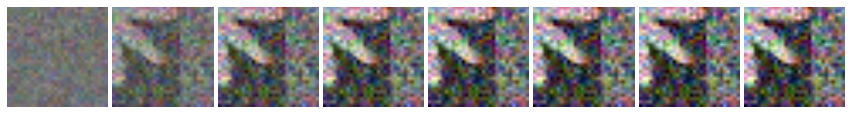

In [289]:
plt.rcParams['figure.subplot.hspace'] = 0
plt.rcParams['figure.subplot.wspace'] = .05

figure(figsize=(15,8))

maxrow = 8
nshow =8

for i in range(nshow):
    ax=subplot(nshow//maxrow+1,maxrow,i+1)
    
    im = draw_ic_im((cc_hista[:, i, :]), ic_comp, nx_patch, ny_patch, patch_size)
    imshow(im)    
    
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_frame_on(False)




**Figure: Clean-up of translated image.** The pointers in the global workspace were manipulated by binding. This results in increments in the pointer addresses, and serves as pointer arithmetic. By appropriately binding the global workspace information, the pointers are altered which attaches the visual features to new locations. The clean-up memory recovers the translated image.

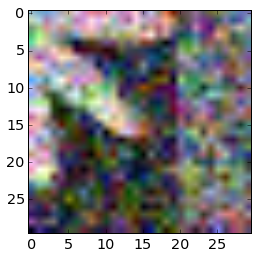

In [290]:
imshow(draw_ic_im(cc_hista[:,-1,:], ic_comp, nx_patch, ny_patch, patch_size))

### Another Example

Doing the same thing, but with more tiles (5x5) and doing vertical and horizontal translation simultaneously.

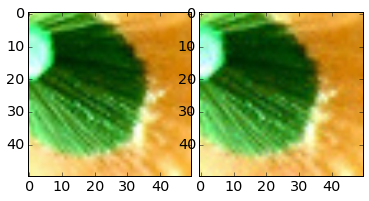

In [343]:
im_idx = 15
icima = np.array(ic_im_vecs)
subplot(121)
imshow(257-impatch[:,:,:,im_idx])
subplot(122)
imshow(draw_ic_im(icima[:,im_idx,:], ic_comp, nx_patch, ny_patch, patch_size))


**Figure: large image represented as tiled features.** 10x10x3 pixels serve as basis functions, 5x5 tiling of these can encode a 50x50x3 image. Left: original, right: tiled encoding.

In [349]:
n_steps = 16

cc_states = []
cc_hist = []
#resonances = []
#eignorm = 1
#obj_resonance = np.dot(np.dot(pinv(obj_vecs), eignorm * np.eye(objD)), obj_vecs)

bound_imvec = np.zeros(N)
cv_inv = []

for iCC in range(len(code_vecs)):
    cc_s = np.random.randn(N)
    cc_h = np.zeros((n_steps, icD))
    
    cv_inv.append(pinv(code_vecs[iCC]))
    imv = np.dot(ic_im_vecs[iCC][im_idx, :], code_vecs[iCC])
    
    bound_imvec += imv
    
    cc_states.append(cc_s)
    cc_hist.append(cc_h)
    eignorm = 1
    #res = np.dot(np.dot(pinv(code_vecs[iCC]), eignorm * np.eye(icD)), code_vecs[iCC])
    #resonances.append(res)
    
bound_imvec = fhrr_bind(fhrr_bind(bound_imvec[np.newaxis], loc_hyperbase[[0],:], pb=1), loc_hyperbase[[1],:], pb=1)
thal_vec = np.zeros(N)

for i in range(n_steps):
    thal_vec[:] = bound_imvec
    #thal_vec[:] = fhrr_bind(thal_vec[np.newaxis], loc_hyperbase[[1],:], pb=0)
    for iCC in range(len(code_vecs)):
        cc_hist[iCC][i,:] = np.dot(code_vecs[iCC]/N, cc_states[iCC]) 
        
        thal_vec -= cc_states[iCC]
        
    for iCC in range(len(code_vecs)):
        cc_upd = np.dot(code_vecs[iCC]/N, thal_vec)
        cc_states[iCC] += np.dot(cc_upd, code_vecs[iCC]) # + 0.5*np.random.randn(N) #np.dot(cv_inv[iCC], cc_upd)
        #cc_states[iCC] = np.dot(cv_inv[iCC], cc_hist[iCC][i,:]) #np.dot(cc_hist[iCC][i,:], code_vecs[iCC])
        #cc_states[iCC] = np.dot(resonances[iCC], thal_vec+cc_states[iCC])
 

In [350]:
cc_hista = np.array(cc_hist)

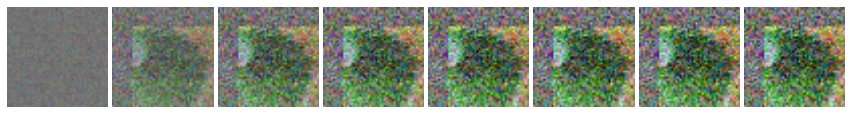

In [353]:
plt.rcParams['figure.subplot.hspace'] = 0
plt.rcParams['figure.subplot.wspace'] = .05

figure(figsize=(15,8))

maxrow = 8
nshow= 8


for i in range(nshow):
    ax=subplot(nshow//maxrow+1,maxrow,i+1)
    
    im = draw_ic_im((cc_hista[:, i, :]), ic_comp, nx_patch, ny_patch, patch_size)
    imshow(im)    
    
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_frame_on(False)




**Figure: clean-up of translated image.** The location pointers were manipulated to shift the image right and down one patch. 

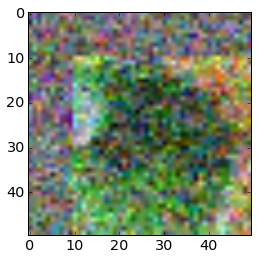

In [354]:
imshow(draw_ic_im(cc_hista[:,-1,:], ic_comp, nx_patch, ny_patch, patch_size))